Import Necessary Libary

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


# Load Fashion MNIST

In [13]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


# Normalize and convert to RGB

In [14]:

x_train = x_train / 255.0
x_test = x_test / 255.0
x_train_rgb = np.stack((x_train,)*3, axis=-1)
x_test_rgb = np.stack((x_test,)*3, axis=-1)


One-hot encode

In [15]:

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

Split train/val

In [16]:

x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train_rgb, y_train_cat, test_size=0.2, random_state=42)

Build tf.data Dataset

In [17]:
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train_final, y_train_final)).map(preprocess).batch(32).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_final, y_val_final)).map(preprocess).batch(32).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test_cat)).map(preprocess).batch(32).prefetch(1)


Load MobileNetV2

In [18]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_transfer = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Compile and Train



In [20]:
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.7811 - loss: 0.6121 - val_accuracy: 0.8647 - val_loss: 0.3584
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.8542 - loss: 0.3880 - val_accuracy: 0.8695 - val_loss: 0.3384
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.8646 - loss: 0.3621 - val_accuracy: 0.8835 - val_loss: 0.3133
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.8717 - loss: 0.3426 - val_accuracy: 0.8829 - val_loss: 0.3129
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.8759 - loss: 0.3271 - val_accuracy: 0.8916 - val_loss: 0.2999
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.8810 - loss: 0.3151 - val_accuracy: 0.8864 - val_loss: 0.3065
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - accuracy: 0.8824 - loss: 0.3077 - val_accuracy: 0.8909 - val_loss: 0.2943
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8845 -

Evaluate and Compare



In [21]:
loss_transfer, acc_transfer = model_transfer.evaluate(test_ds)
print(f"✅ Transfer Learning Accuracy: {acc_transfer:.4f}")

# Example if you had a scratch model result
# print(f"✅ CNN-from-Scratch Accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8939 - loss: 0.2838
✅ Transfer Learning Accuracy: 0.8938


Curve plot

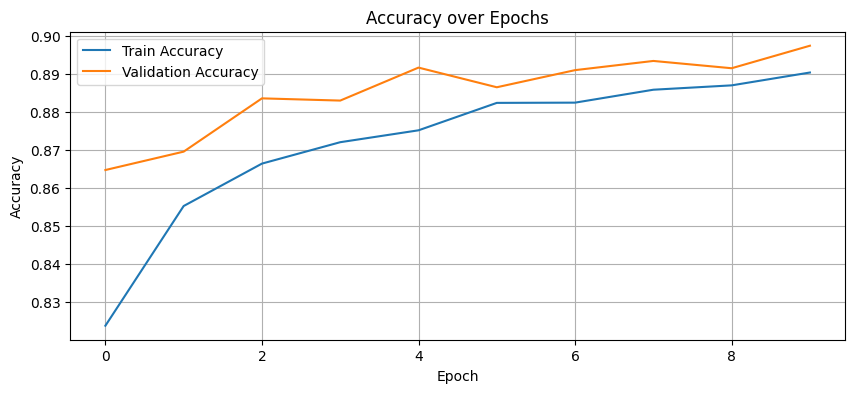

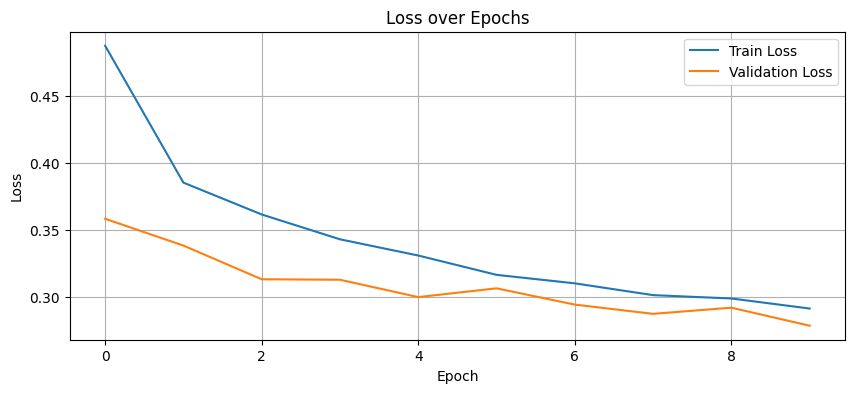

In [22]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10,4))
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10,4))
plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
